#**Load Celeba dataset from Kaggle**

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files

Upload kaggle.json file:

In [ ]:
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"michalegucki","key":"dec10efc38cdf08c483ce48dd1520898"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d jessicali9530/celeba-dataset
!unzip celeba-dataset.zip -d celeba
!rm celeba-dataset.zip

Strumieniowane dane wyjściowe obcięte do 5000 ostatnich wierszy.
  inflating: celeba/img_align_celeba/img_align_celeba/197604.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197605.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197606.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197607.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197608.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197609.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197610.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197611.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197612.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197613.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197614.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197615.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197616.jpg  
  inflating: celeba/img_align_celeba/img_align_celeba/197617.jpg

In [ ]:
pip install torch-fidelity


In [ ]:
#Importing packages:
import pickle as pkl
import matplotlib.pyplot as plt
%matplotlib inline
import random
from random import randrange, uniform
import numpy as np

import torch
from torchvision import datasets
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch_fidelity import calculate_metrics

In [ ]:
#Images folder path in google colab:
PATH = '/content/'

In [ ]:
#Image Param:
'''Image size defined here will be used as input and output.
This will be the size of images used to train the model and the ones
generated by the network'''
IMG_SIZE = 32

#Training params: 
BATCH_SIZE = 64
KERNEL_SIZE = 4

##**Generator danych do trenowania**

In [ ]:
#DATA GENERATOR:

def get_dataloader(batch_size, image_size, data_dir=PATH):
  '''
      This function prepares data in batches that will be fed to model during training
      process. It also preprocesses the images.
      params:
              data_dir - path to training dataset
              batch_size - batch size
              image_size - output HxW of the image that will be returned
  '''
  #Image transformations: 
  transform = transforms.Compose([
                                  transforms.Resize((image_size, image_size)),
                                  transforms.CenterCrop(image_size),
                                  transforms.ToTensor(),
                                  transforms.Normalize(mean=(0.5,0.5,0.5), std=(0.5,0.5,0.5))
  ])

  dataset = datasets.ImageFolder(data_dir, transform=transform)
  image_transforms = transforms.Compose([
                                         transforms.Resize((image_size, image_size)),
                                         transforms.ToTensor()
  ])

  dataloader = torch.utils.data.DataLoader(datasets.ImageFolder(data_dir, transform=image_transforms), shuffle=True, batch_size=BATCH_SIZE)

  return dataloader

In [ ]:
celeba_train_loader = get_dataloader(BATCH_SIZE, IMG_SIZE)

In [ ]:
celeba_train_loader

##**Display some samples after preprocessing:**

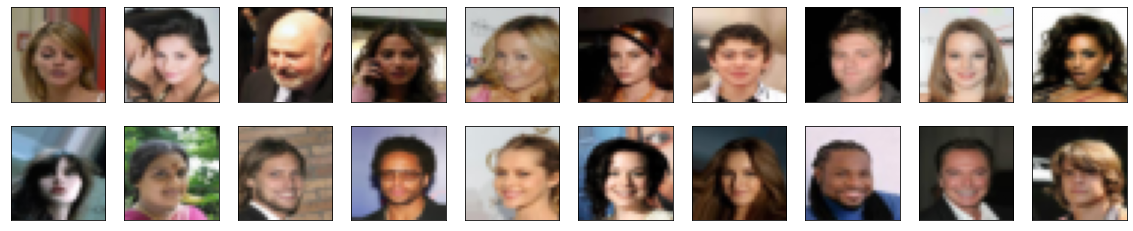

In [ ]:
#Displaying sample images:
def imshow(img):
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))

#Pobranie jednego batcha obrazów:
dataiter = iter(celeba_train_loader)
images, _ = dataiter.next()

fig = plt.figure(figsize=(20,4))
plot_size = 20
for idx in np.arange(plot_size):
  ax = fig.add_subplot(2, plot_size/2, idx+1, xticks=[], yticks=[])
  imshow(images[idx])

In [ ]:
#Shape of sample image:
images[0].shape

torch.Size([3, 32, 32])

Shape is perfect - 3 channels (RGB), 32x32 pixels

In [ ]:
#Rescaling the images from range 0 to 1 to range of -1 to 1:

def scale(x, feature_range=(-1,1)):
  min, max = feature_range
  x = x * (max-min) + min
  return x

In [ ]:
print(images[0][0][0])
print(scale(images[0])[0][0])

tensor([0.5922, 0.5961, 0.6000, 0.6039, 0.6196, 0.6078, 0.5294, 0.5765, 0.6118,
        0.6118, 0.5843, 0.3725, 0.4824, 0.5137, 0.5333, 0.5255, 0.4667, 0.3922,
        0.4039, 0.4902, 0.5725, 0.5686, 0.5608, 0.5961, 0.6000, 0.5843, 0.4235,
        0.2510, 0.2863, 0.3098, 0.5490, 0.5804])
tensor([ 0.1843,  0.1922,  0.2000,  0.2078,  0.2392,  0.2157,  0.0588,  0.1529,
         0.2235,  0.2235,  0.1686, -0.2549, -0.0353,  0.0275,  0.0667,  0.0510,
        -0.0667, -0.2157, -0.1922, -0.0196,  0.1451,  0.1373,  0.1216,  0.1922,
         0.2000,  0.1686, -0.1529, -0.4980, -0.4275, -0.3804,  0.0980,  0.1608])


All looks good - the photos has been scaled to -1 to 1

#**Model definition**

##**Discriminator**

In [ ]:
def conv(in_channels, out_channels, kernel_size=KERNEL_SIZE, stride=2, padding=1, batch_norm=True):
  '''
      Function creating the convolutional layers for the discriminator
  '''
  layers = []
  conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
  layers.append(conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [ ]:
class Discriminator(nn.Module):

  '''
      Discriminator class that will take an 32x32 image as an input and process
      it to the last layer that will output single value: 0 or 1 that says
      if the photo is real or fake.
  '''
  
  def __init__(self, conv_dim):
    super(Discriminator, self).__init__()
    self.conv_dim = conv_dim

    #Defining the convolutional layers. They should accept an 32x32 RGB image as an input and output a single value.

    self.conv1 = conv(3, conv_dim, 4, batch_norm=False)

    #Output 16x16:
    self.conv2 = conv(conv_dim, conv_dim*2, 4)
  
    #Output 8x8:
    self.conv3 = conv(conv_dim*2, conv_dim*4, 4)

    #Output 4x4:
    self.conv4 = conv(conv_dim*4, conv_dim*8, 4)

    #Output 2x2 and FullyConnected layer:
    self.fc = nn.Linear(conv_dim*8*2*2, 1)   #Keras equivalent to Dense Layer

    #Sigmoid activation function for last layer:
    self.out = nn.Sigmoid()

    #Dropout:
    self.dropout = nn.Dropout(0.5)
  
  def forward(self, x):
    #Forward propagation of the neural network:
    out = F.leaky_relu(self.conv1(x), 0.2)
    out = F.leaky_relu(self.conv2(out), 0.2)
    out = F.leaky_relu(self.conv3(out), 0.2)
    out = F.leaky_relu(self.conv4(out), 0.2)

    out = out.view(-1, self.conv_dim*8*2*2)

    x = self.fc(out)

    return x
  

##**Generator**

In [ ]:
def deconv(in_channels, out_channels, kernel_size=KERNEL_SIZE, stride=2, padding=1, batch_norm=True):
  '''
    Function creating the deconvolutional layers for the Generator
  '''
  layers = []
  transpose_conv_layer = nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias=False)

  layers.append(transpose_conv_layer)

  if batch_norm:
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [ ]:
class Generator(nn.Module):
  '''
      Generator class that takes random noise as an input and transforms it to
      what it thinks is a photo of a person that is then forwarded for classification
      by the Discriminator
  '''
  def __init__(self, z_size, conv_dim):
    '''
        params:
                z_size - length of a latent vector used in a network
                conv_dim - input size for the last convolutional layer
    '''
    super(Generator, self).__init__()

    self.conv_dim = conv_dim
    #Fully connected layer:
    self.fc = nn.Linear(z_size, conv_dim*8*2*2)

    self.deconv1 = deconv(conv_dim*8, conv_dim*4, 4)
    self.deconv2 = deconv(conv_dim*4, conv_dim*2, 4)
    self.deconv3 = deconv(conv_dim*2, conv_dim, 4)
    self.deconv4 = deconv(conv_dim, 3, 4, batch_norm=False)

  def forward(self, x):
    '''
        Forward propagation of a Neural network:
        param x: network input
        returns: 32x32x3 tensor (image)
    '''
    out = self.fc(x)

    out = out.view(-1, self.conv_dim*8, 2, 2)

    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))
    out = F.relu(self.deconv3(out))

    out = self.deconv4(out)
    x = torch.tanh(out)

    return x

##**Weights initialization:**

In [ ]:
def weights_init_normal(m):
  '''
      Initializes the weights for certain layers in the network.
      Weights are a normal distribution with mean = 0 and std dev = 0.02
      param m: network layer
  '''

  classname = m.__class__.__name__ # Name of a given layer

  #If has a certain attribute and name - aplly the weights:
  if hasattr(m, 'weight') and (classname.find('Conv') != -1 or classname.find('Linear') != -1):
    m.weight.data.normal_(0.0, 0.02)
    if hasattr(m, 'bias') and m.bias is not None:
      m.bias.data.zero_()

#**Buliding full network:**

In [ ]:
def build_network(d_conv_dim, g_conv_dim, z_size):
  #Creating Discriminator and Generator instances:
  D = Discriminator(d_conv_dim)
  G = Generator(z_size=z_size, conv_dim=g_conv_dim)

  #Weights initialization:
  D.apply(weights_init_normal)
  G.apply(weights_init_normal)

  print(D)
  print()
  print(G)
  return D, G

In [ ]:
#Define model hyperparameters:
d_conv_dim = 64
g_conv_dim = 64
z_size = 100

#Build the network:
D, G = build_network(d_conv_dim, g_conv_dim, z_size)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
  (out): Sigmoid()
  (dropout): Dropout(p=0.5, inplace=False)
)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(512, 25

**Using GPU for training:**

In [ ]:
train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
  print("GPU not found. Please change the environment to GPU and try again!")
else:
  print('Training on GPU')

Training on GPU


##**Generator and Discriminator loss**

In [ ]:
#Function that collects loss during model training:
def real_loss(D_out, smooth=False):
  
  batch_size = D_out.size(0)

  #Smoothing:
  if smooth:
    labels = torch.ones(batch_size)*0.9
  else:
    labels = torch.ones(batch_size)

  if train_on_gpu:
    labels = labels.cuda()
  
  #Binary Cross-Entropy with Logits Loss:
  criterion = nn.BCEWithLogitsLoss()

  loss = criterion(D_out.squeeze(), labels)

  return loss

def fake_loss(D_out):

  batch_size = D_out.size(0)

  labels = torch.zeros(batch_size)

  if train_on_gpu:
    labels = labels.cuda()
  
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(D_out.squeeze(), labels)

  return loss


##**Optymizatory**

In [ ]:
#Adam optimizer
d_optimizer = optim.Adam(D.parameters(), lr=0.0005, betas=(0.4, 0.999))
g_optimizer = optim.Adam(G.parameters(), lr=0.0005, betas=(0.4, 0.999))

#**Trenowanie modelu:**

In [ ]:
def save_images(images, path):
  for idx, image in enumerate(images):
    save_image(image, f'{path}{idx+1}.png')

def empty_folder(path):
  files = os.listdir(path)
  for file in files:
    os.remove(os.path.join(path, file))


In [ ]:
from torch_fidelity import register_dataset
from torchvision.utils import save_image
import os

In [ ]:
def train(D, G, n_epochs=10, print_every=50):
  """Trenuje sieć GAN przez {n_epochs} liczbę razy.
  D - dyskryminator
  G - generator
  print_every - co ile kroków printować i zapisać lossy
  zwraca - lossy D i G"""

  #Code below checks if train_on_gpu is True and if so transfers the
  #calculations to GPU device. Repeats many times down below.
  if train_on_gpu:
    D.cuda()
    G.cuda()
  
  samples = []
  losses  = []
  metrics = []

  #Define fixed thata that will not change during training process and will be
  #used to evaluate the model:
  sample_size = 39
  fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size))
  fixed_z = torch.from_numpy(fixed_z).float()

  if train_on_gpu:
    fixed_z = fixed_z.cuda()
  
  for epoch in range(n_epochs):
    for batch_i, (real_images, _) in enumerate(celeba_train_loader):
      batch_size = real_images.size(0)
      real_images = scale(real_images)

      d_optimizer.zero_grad()

      if train_on_gpu:
        real_images = real_images.cuda()
      #Discriminator training on real and fake images:
      #Discriminator loss calculation:
      D_real = D(real_images)
      d_real_loss = real_loss(D_real)

      #Fake images generation:
      z_fake = np.random.uniform(-1, 1, size=(batch_size, z_size))
      z_fake = torch.from_numpy(z_fake).float()

      if train_on_gpu:
        z_fake = z_fake.cuda()
      fake_images = G(z_fake)

      #Discriminator loss calculation:
      D_fake = D(fake_images)
      d_fake_loss = fake_loss(D_fake)
      
      #Loss sum and backward propagarion
      d_loss = d_real_loss + d_fake_loss
      d_loss.backward()
      d_optimizer.step()

      #Generator training:

      g_optimizer.zero_grad()

      #Fake images generation:
      z_fake = np.random.uniform(-1, 1, size=(batch_size, z_size))
      z_fake = torch.from_numpy(z_fake).float()

      if train_on_gpu:
        z_fake = z_fake.cuda()
      fake_images = G(z_fake)

      D_fake = D(fake_images)

      g_loss = real_loss(D_fake, True)

      g_loss.backward()
      g_optimizer.step()

      if batch_i % print_every == 0:
        losses.append((d_loss.item(), g_loss.item()))
        print(f"Epoch: {epoch+1}/{n_epochs} | d_loss: {d_loss.item()}, g_loss: {g_loss.item()}")
      
    #Saving images generated during training:
    G.eval()
    samples_z = G(fixed_z)

    #Saving real and fake images to calculate metrics used to EarlyStop the training model.
    #FID Score is used for GAN evaluation. As long as the FID score is increasing
    #The training is considered to be effective. If the FID starts to decrease
    #it is considered to be the good point to stop the training.
    save_images(real_images, 'real_images/')
    save_images(samples_z, 'fake_images/')
    fid_metrics = calculate_metrics('real_images/', 'fake_images/', cuda=True, isc=True, fid=True)
    print(f'FID Metrics: {fid_metrics}')
    metrics.append(fid_metrics)
    empty_folder('real_images/')
    empty_folder('fake_images/')

    samples.append(samples_z)
    G.train()

  with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)
  
  return losses, metrics



In [ ]:
N_EPOCHS = 20
z_size = 100

losses, metrics = train(D, G, n_epochs = N_EPOCHS)


Epoch: 1/20 | d_loss: 0.3390926122665405, g_loss: 2.434777021408081


















































Epoch: 1/20 | d_loss: 0.4981023371219635, g_loss: 2.1580488681793213


















































Epoch: 1/20 | d_loss: 0.39959511160850525, g_loss: 2.9371936321258545


















































Epoch: 1/20 | d_loss: 0.697099506855011, g_loss: 3.6525187492370605


















































Epoch: 1/20 | d_loss: 0.38335439562797546, g_loss: 1.9919605255126953


















































Epoch: 1/20 | d_loss: 0.2576174736022949, g_loss: 1.1915302276611328


















































Epoch: 1/20 | d_loss: 0.72737717628479, g_loss: 1.422567367553711


















































Epoch: 1/20 | d_loss: 0.35066285729408264, g_loss: 2.623432159423828


















































Epoch: 1/20 | d_loss: 1.0476199388504028, g_loss: 

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 2.005527377820755, 'inception_score_std': 0.3503406013117457, 'frechet_inception_distance': 168.87026827368825}

Epoch: 2/20 | d_loss: 0.9030024409294128, g_loss: 2.283816337585449


















































Epoch: 2/20 | d_loss: 0.9825021028518677, g_loss: 5.424818992614746


















































Epoch: 2/20 | d_loss: 0.4487411379814148, g_loss: 4.651954650878906


















































Epoch: 2/20 | d_loss: 0.18831920623779297, g_loss: 1.9223871231079102


















































Epoch: 2/20 | d_loss: 0.2945154011249542, g_loss: 3.5821266174316406


















































Epoch: 2/20 | d_loss: 0.38133105635643005, g_loss: 2.820845127105713


















































Epoch: 2/20 | d_loss: 0.6838849186897278, g_loss: 1.746274709701538


















































Epoch: 2/20 | d_los

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9236469878808276, 'inception_score_std': 0.17772395352644985, 'frechet_inception_distance': 166.35373262179957}

Epoch: 3/20 | d_loss: 0.35745349526405334, g_loss: 2.4242353439331055


















































Epoch: 3/20 | d_loss: 0.29153698682785034, g_loss: 2.2877001762390137


















































Epoch: 3/20 | d_loss: 0.6123856902122498, g_loss: 3.1119964122772217


















































Epoch: 3/20 | d_loss: 0.3289124667644501, g_loss: 2.162750244140625


















































Epoch: 3/20 | d_loss: 0.5350750088691711, g_loss: 4.2249250411987305


















































Epoch: 3/20 | d_loss: 0.5495796203613281, g_loss: 1.396681785583496


















































Epoch: 3/20 | d_loss: 0.19540441036224365, g_loss: 2.9173238277435303


















































Epoch: 3/20 |

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.8184454362896108, 'inception_score_std': 0.2546994835748027, 'frechet_inception_distance': 157.46363583266805}

Epoch: 4/20 | d_loss: 0.054739296436309814, g_loss: 3.507093906402588


















































Epoch: 4/20 | d_loss: 0.12045301496982574, g_loss: 3.5201032161712646


















































Epoch: 4/20 | d_loss: 0.13867315649986267, g_loss: 3.6691484451293945


















































Epoch: 4/20 | d_loss: 0.17434149980545044, g_loss: 5.293695449829102


















































Epoch: 4/20 | d_loss: 0.4223240315914154, g_loss: 1.8561267852783203


















































Epoch: 4/20 | d_loss: 0.25559014081954956, g_loss: 2.5603301525115967


















































Epoch: 4/20 | d_loss: 0.5748833417892456, g_loss: 1.139460802078247


















































Epoch: 4/20 

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.8005150913269996, 'inception_score_std': 0.29162365983291416, 'frechet_inception_distance': 156.21473375132126}

Epoch: 5/20 | d_loss: 0.45892664790153503, g_loss: 3.07900071144104


















































Epoch: 5/20 | d_loss: 0.3683195114135742, g_loss: 6.02805233001709


















































Epoch: 5/20 | d_loss: 0.13412317633628845, g_loss: 4.117151260375977


















































Epoch: 5/20 | d_loss: 0.42888936400413513, g_loss: 4.966038703918457


















































Epoch: 5/20 | d_loss: 0.21477244794368744, g_loss: 5.106854438781738


















































Epoch: 5/20 | d_loss: 1.7214365005493164, g_loss: 0.7893502712249756


















































Epoch: 5/20 | d_loss: 0.31882333755493164, g_loss: 4.914409160614014


















































Epoch: 5/20 | d_l

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.7529039687628643, 'inception_score_std': 0.3031825236166404, 'frechet_inception_distance': 156.42805024703927}

Epoch: 6/20 | d_loss: 0.2194114774465561, g_loss: 3.2846972942352295


















































Epoch: 6/20 | d_loss: 0.1446201503276825, g_loss: 4.017087936401367


















































Epoch: 6/20 | d_loss: 0.10408088564872742, g_loss: 5.536314010620117


















































Epoch: 6/20 | d_loss: 0.1978626847267151, g_loss: 3.7864675521850586


















































Epoch: 6/20 | d_loss: 0.18815919756889343, g_loss: 4.102398872375488


















































Epoch: 6/20 | d_loss: 0.09149932116270065, g_loss: 4.646582126617432


















































Epoch: 6/20 | d_loss: 0.7295135259628296, g_loss: 3.614123821258545


















































Epoch: 6/20 | d_l

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9803975077803517, 'inception_score_std': 0.25125068964886654, 'frechet_inception_distance': 161.03610509704265}

Epoch: 7/20 | d_loss: 0.7654610276222229, g_loss: 5.687468528747559


















































Epoch: 7/20 | d_loss: 0.16810745000839233, g_loss: 5.097185134887695


















































Epoch: 7/20 | d_loss: 0.09445400536060333, g_loss: 3.9033796787261963


















































Epoch: 7/20 | d_loss: 0.131853386759758, g_loss: 4.317061424255371


















































Epoch: 7/20 | d_loss: 0.284046471118927, g_loss: 3.6004714965820312


















































Epoch: 7/20 | d_loss: 0.887225866317749, g_loss: 4.545166015625


















































Epoch: 7/20 | d_loss: 0.6938512325286865, g_loss: 5.836722373962402


















































Epoch: 7/20 | d_loss: 0

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9363217890132156, 'inception_score_std': 0.29462078865650854, 'frechet_inception_distance': 169.60430524477368}

Epoch: 8/20 | d_loss: 0.20611591637134552, g_loss: 5.465330600738525


















































Epoch: 8/20 | d_loss: 0.12262862175703049, g_loss: 5.733092308044434


















































Epoch: 8/20 | d_loss: 0.12527497112751007, g_loss: 3.0232186317443848


















































Epoch: 8/20 | d_loss: 0.09237879514694214, g_loss: 3.5390398502349854


















































Epoch: 8/20 | d_loss: 0.08689503371715546, g_loss: 5.578725814819336


















































Epoch: 8/20 | d_loss: 0.23312225937843323, g_loss: 2.884164810180664


















































Epoch: 8/20 | d_loss: 0.2311251014471054, g_loss: 4.531407356262207


















































Epoch: 8/20 |

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.6841625647161393, 'inception_score_std': 0.09553888133994255, 'frechet_inception_distance': 173.49488850133662}

Epoch: 9/20 | d_loss: 0.8554302453994751, g_loss: 6.656062126159668


















































Epoch: 9/20 | d_loss: 0.24499332904815674, g_loss: 3.1099905967712402


















































Epoch: 9/20 | d_loss: 0.10874325782060623, g_loss: 4.360136985778809


















































Epoch: 9/20 | d_loss: 0.4703828990459442, g_loss: 2.937504291534424


















































Epoch: 9/20 | d_loss: 0.3641814887523651, g_loss: 4.355155944824219


















































Epoch: 9/20 | d_loss: 0.037989627569913864, g_loss: 5.349270820617676


















































Epoch: 9/20 | d_loss: 0.11728319525718689, g_loss: 4.061270713806152


















































Epoch: 9/20 | d

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9377283314103522, 'inception_score_std': 0.3809620937765847, 'frechet_inception_distance': 154.84438172059316}

Epoch: 10/20 | d_loss: 0.04889090359210968, g_loss: 4.458952903747559


















































Epoch: 10/20 | d_loss: 0.055859021842479706, g_loss: 4.786529541015625


















































Epoch: 10/20 | d_loss: 0.4633238613605499, g_loss: 5.422823429107666


















































Epoch: 10/20 | d_loss: 0.03649464622139931, g_loss: 4.6190643310546875


















































Epoch: 10/20 | d_loss: 0.1798018217086792, g_loss: 4.032500743865967


















































Epoch: 10/20 | d_loss: 0.9704990983009338, g_loss: 0.5928299427032471


















































Epoch: 10/20 | d_loss: 0.23736530542373657, g_loss: 5.368924140930176


















































Epoch: 1

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9055423977619366, 'inception_score_std': 0.1998194753299803, 'frechet_inception_distance': 153.23313296679814}

Epoch: 11/20 | d_loss: 0.09286565333604813, g_loss: 3.5694384574890137


















































Epoch: 11/20 | d_loss: 0.15581774711608887, g_loss: 5.493092060089111


















































Epoch: 11/20 | d_loss: 0.25231674313545227, g_loss: 3.0925941467285156


















































Epoch: 11/20 | d_loss: 0.03962727636098862, g_loss: 3.315103769302368


















































Epoch: 11/20 | d_loss: 0.08081867545843124, g_loss: 5.859106063842773


















































Epoch: 11/20 | d_loss: 0.053165871649980545, g_loss: 5.3912200927734375


















































Epoch: 11/20 | d_loss: 0.14745940268039703, g_loss: 5.991569519042969


















































Epoc

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9991000949672493, 'inception_score_std': 0.38660961663815857, 'frechet_inception_distance': 156.3683978338314}

Epoch: 12/20 | d_loss: 2.3465540409088135, g_loss: 3.2746100425720215


















































Epoch: 12/20 | d_loss: 0.07110416889190674, g_loss: 3.221205234527588


















































Epoch: 12/20 | d_loss: 0.29169678688049316, g_loss: 6.363943576812744


















































Epoch: 12/20 | d_loss: 0.2982046604156494, g_loss: 4.209300518035889


















































Epoch: 12/20 | d_loss: 0.10247702151536942, g_loss: 4.318544387817383


















































Epoch: 12/20 | d_loss: 0.04056200385093689, g_loss: 6.64322566986084


















































Epoch: 12/20 | d_loss: 0.24527347087860107, g_loss: 5.100595474243164


















































Epoch: 12/

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9564243658082057, 'inception_score_std': 0.2974548581847474, 'frechet_inception_distance': 158.27055842140334}

Epoch: 13/20 | d_loss: 1.2657835483551025, g_loss: 2.343217372894287


















































Epoch: 13/20 | d_loss: 0.15714839100837708, g_loss: 4.158853054046631


















































Epoch: 13/20 | d_loss: 0.049084533005952835, g_loss: 3.728849411010742


















































Epoch: 13/20 | d_loss: 0.12476742267608643, g_loss: 4.738744735717773


















































Epoch: 13/20 | d_loss: 0.028699392452836037, g_loss: 5.218238353729248


















































Epoch: 13/20 | d_loss: 0.11412607133388519, g_loss: 6.369823455810547


















































Epoch: 13/20 | d_loss: 0.08133092522621155, g_loss: 2.924757480621338


















































Epoch: 

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 2.028891910413651, 'inception_score_std': 0.5116864295070805, 'frechet_inception_distance': 157.0801050824476}

Epoch: 14/20 | d_loss: 0.08458252251148224, g_loss: 4.620634078979492


















































Epoch: 14/20 | d_loss: 0.15725678205490112, g_loss: 5.148871421813965


















































Epoch: 14/20 | d_loss: 0.20026502013206482, g_loss: 2.378032684326172


















































Epoch: 14/20 | d_loss: 0.03195246309041977, g_loss: 4.800508499145508


















































Epoch: 14/20 | d_loss: 0.03829649090766907, g_loss: 4.969289779663086


















































Epoch: 14/20 | d_loss: 0.030788835138082504, g_loss: 5.5101776123046875


















































Epoch: 14/20 | d_loss: 0.06894394010305405, g_loss: 5.071472644805908


















































Epoch: 1

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.7880470204801988, 'inception_score_std': 0.15536066860995087, 'frechet_inception_distance': 152.36096548372416}

Epoch: 15/20 | d_loss: 0.0905877947807312, g_loss: 5.558439254760742


















































Epoch: 15/20 | d_loss: 0.08384540677070618, g_loss: 5.010677814483643


















































Epoch: 15/20 | d_loss: 0.021878108382225037, g_loss: 5.419343948364258


















































Epoch: 15/20 | d_loss: 0.3498755991458893, g_loss: 4.129886627197266


















































Epoch: 15/20 | d_loss: 0.031232992187142372, g_loss: 7.140749931335449


















































Epoch: 15/20 | d_loss: 0.1439487785100937, g_loss: 5.517899513244629


















































Epoch: 15/20 | d_loss: 0.4151608347892761, g_loss: 1.925590991973877


















































Epoch: 15

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.8951232304624774, 'inception_score_std': 0.2326305499186983, 'frechet_inception_distance': 154.66857180744879}

Epoch: 16/20 | d_loss: 0.3699411153793335, g_loss: 6.156975746154785


















































Epoch: 16/20 | d_loss: 0.03697824478149414, g_loss: 5.769163131713867


















































Epoch: 16/20 | d_loss: 0.03151918575167656, g_loss: 5.37427282333374


















































Epoch: 16/20 | d_loss: 0.03928487002849579, g_loss: 5.413241386413574


















































Epoch: 16/20 | d_loss: 0.06692922860383987, g_loss: 4.807502746582031


















































Epoch: 16/20 | d_loss: 0.0880843997001648, g_loss: 4.151178359985352


















































Epoch: 16/20 | d_loss: 0.08359293639659882, g_loss: 4.900727272033691


















































Epoch: 16/2

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 2.0842912812892433, 'inception_score_std': 0.2711139268822767, 'frechet_inception_distance': 163.65978415917823}

Epoch: 17/20 | d_loss: 0.3917035460472107, g_loss: 6.159334182739258


















































Epoch: 17/20 | d_loss: 0.048595115542411804, g_loss: 3.354482650756836


















































Epoch: 17/20 | d_loss: 0.05698760226368904, g_loss: 4.342338562011719


















































Epoch: 17/20 | d_loss: 0.04853308945894241, g_loss: 7.634865760803223


















































Epoch: 17/20 | d_loss: 0.06264474987983704, g_loss: 4.355611801147461


















































Epoch: 17/20 | d_loss: 0.34812942147254944, g_loss: 5.184409141540527


















































Epoch: 17/20 | d_loss: 0.06903116405010223, g_loss: 5.609963417053223


















































Epoch: 1

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 2.0447066799824887, 'inception_score_std': 0.3246749211679782, 'frechet_inception_distance': 160.29453757297915}

Epoch: 18/20 | d_loss: 0.019453871995210648, g_loss: 6.640724182128906


















































Epoch: 18/20 | d_loss: 0.11556317657232285, g_loss: 7.306601524353027


















































Epoch: 18/20 | d_loss: 0.10760411620140076, g_loss: 5.987349987030029


















































Epoch: 18/20 | d_loss: 0.13330356776714325, g_loss: 4.5940375328063965


















































Epoch: 18/20 | d_loss: 0.05039343982934952, g_loss: 4.253895282745361


















































Epoch: 18/20 | d_loss: 0.14277924597263336, g_loss: 5.5906147956848145


















































Epoch: 18/20 | d_loss: 0.048143237829208374, g_loss: 4.318453788757324


















































Epoc

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9151363739557958, 'inception_score_std': 0.24736293003686202, 'frechet_inception_distance': 139.0264484954595}

Epoch: 19/20 | d_loss: 0.07156014442443848, g_loss: 4.650187969207764


















































Epoch: 19/20 | d_loss: 0.06163261458277702, g_loss: 5.694218635559082


















































Epoch: 19/20 | d_loss: 0.04086034372448921, g_loss: 4.411676406860352


















































Epoch: 19/20 | d_loss: 0.011174848303198814, g_loss: 5.782472610473633


















































Epoch: 19/20 | d_loss: 0.04674970358610153, g_loss: 3.659895181655884


















































Epoch: 19/20 | d_loss: 0.12063533067703247, g_loss: 5.043628692626953


















































Epoch: 19/20 | d_loss: 0.038002487272024155, g_loss: 6.130937576293945


















































Epoch:

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.9413643556586742, 'inception_score_std': 0.3273244584557041, 'frechet_inception_distance': 148.4421262384352}

Epoch: 20/20 | d_loss: 0.03407619893550873, g_loss: 5.15100622177124


















































Epoch: 20/20 | d_loss: 0.11011269688606262, g_loss: 5.027942657470703


















































Epoch: 20/20 | d_loss: 0.06039039045572281, g_loss: 5.326360702514648


















































Epoch: 20/20 | d_loss: 0.05953926593065262, g_loss: 5.109564781188965


















































Epoch: 20/20 | d_loss: 0.009876715019345284, g_loss: 5.100612640380859


















































Epoch: 20/20 | d_loss: 0.029077649116516113, g_loss: 5.518798828125


















































Epoch: 20/20 | d_loss: 0.10659793764352798, g_loss: 5.688794136047363


















































Epoch: 20/2

Creating feature extractor "inception-v3-compat" with features ['2048', 'logits_unbiased']
Extracting features from input_1
Looking for samples non-recursivelty in "real_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Extracting features from input_2
Looking for samples non-recursivelty in "fake_images/" with extensions png,jpg,jpeg
Found 39 samples
Processing samples
Computing Inception Score
Computing Frechet Inception Distance


FID Metrics: {'inception_score_mean': 1.8780194307731968, 'inception_score_std': 0.1764762374692336, 'frechet_inception_distance': 152.63978376880027}


In [ ]:
print(metrics)

[{'inception_score_mean': 1.909282033328417, 'inception_score_std': 0.2784505513828403, 'frechet_inception_distance': 156.51359351905282}, {'inception_score_mean': 1.8670266848020496, 'inception_score_std': 0.23911618121638983, 'frechet_inception_distance': 156.96362156307916}]


In [ ]:
# !rm -r real_images
# !rm -r fake_images
# !mkdir real_images
# !mkdir fake_images

##**Generator and Discriminator loss plot:**

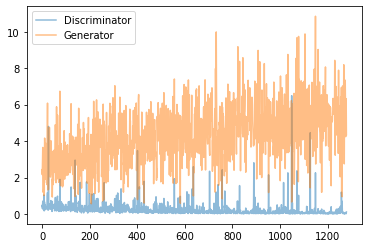

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.legend()

##**FID scores plot:**

In [ ]:
ism_scores = []
i_scores = []
fid_scores = []

for index in range(len(metrics)):
  ism_scores.append(metrics[index]['frechet_inception_distance'])
  i_scores.append(metrics[index]['inception_score_mean'])
  fid_scores.append(metrics[index]['inception_score_std'])

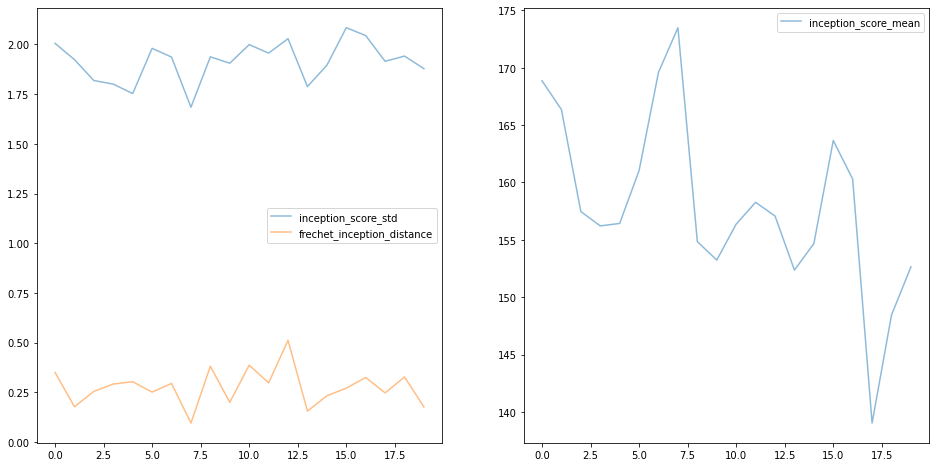

In [ ]:
fig = plt.figure(figsize=(16,8))
ax = fig.add_subplot(1, 2, 1)
plt.plot(i_scores, label='inception_score_std', alpha=0.5)
plt.plot(fid_scores, label='frechet_inception_distance', alpha=0.5)
plt.legend()
ax = fig.add_subplot(1,2,2)
plt.plot(ism_scores, label='inception_score_mean', alpha=0.5)
plt.legend()


In [ ]:
# Helper function to display generated samples:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img + 1)*255 / (2)).astype(np.uint8)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

In [ ]:
# Loads pickled samples from generator:
with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

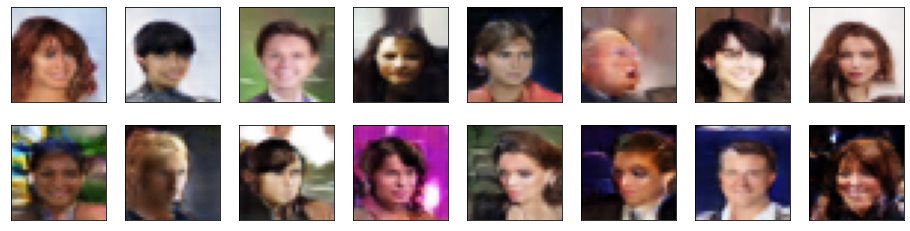

In [ ]:
_ = view_samples(-1, samples)